# 导入必要库

In [ ]:
from pathlib import Path
import gc
import time

from core import RLEnv
from core.agent import BaseAgent
from greedy import (
    EpsilonDecreasingConfig,
    GreedyAgent,
    greedy_average,
    epsilon_average,
    epsilon_decreasing_average,
)
from ucb1 import UCBAgent, ucb1

from train import batch_train
from utils import plot_metrics_history, save_experiment_data, ProcessDataLogger

In [2]:
STEPS: int = 100_000
GRID_SIZE: int = 500

SEED: int = 42
MACHINE_COUNT: int = 10
COUNT: int = 50
CONVERGENCE_THRESHOLD: float = 0.9
CONVERGENCE_MIN_STEPS: int = 1000
OPTIMISTIC_TIMES: int = 1
ENABLE_OPTIMISTIC: bool = True
EXPERIMENT_DATA_DIR: Path = Path.cwd() / "experiment_data"

ENV: RLEnv = RLEnv(machine_count=MACHINE_COUNT, seed=SEED)
EPSILON_CONFIG: EpsilonDecreasingConfig = EpsilonDecreasingConfig()

# 工厂函数

In [3]:
def get_run_id(agent_name: str) -> str:
    return agent_name + str(time.time())

In [4]:
def create_greedy_agent(
    env: RLEnv, 
    epsilon_config: EpsilonDecreasingConfig, 
    optimistic_init: bool, 
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=greedy_average.__name__,
        env=env,
        greedy_algorithm=greedy_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

def create_epsilon_agent(
    env: RLEnv, 
    epsilon_config: EpsilonDecreasingConfig, 
    optimistic_init: bool, 
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=epsilon_average.__name__,
        env=env,
        greedy_algorithm=epsilon_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

def create_decreasing_agent(
    env: RLEnv, 
    epsilon_config: EpsilonDecreasingConfig, 
    optimistic_init: bool, 
    optimistic_times: int,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return GreedyAgent(
        name=epsilon_decreasing_average.__name__,
        env=env,
        greedy_algorithm=epsilon_decreasing_average,
        epsilon_config=epsilon_config,
        optimistic_init=optimistic_init,
        optimistic_times=optimistic_times,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

In [5]:
def create_ucb1_agent(
    env: RLEnv,
    convergence_threshold: float,
    convergence_min_steps: int,
    seed: int,
) -> BaseAgent:
    return UCBAgent(
        name=ucb1.__name__,
        env=env,
        ucb1_algorithm=ucb1,
        convergence_threshold=convergence_threshold,
        convergence_min_steps=convergence_min_steps,
        seed=seed,
    )

# 训练

## 普通贪婪算法

达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1250
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1000
avg_regret=3637.7109090909116 avg_regret_rate=0.04001482000000005 avg_total_reward=87271.38 avg_optimal_rate=0.7197880000000002 avg_convergence_steps=725.0 avg_convergence_rate=0.72
values=[0.14, 0.26, 0.5, 0.7, 0.98, 3.5, 1273.28, 5815.76, 14737.92, 65438.34] counts=[1.14, 1.26, 1.54, 1.7, 2.0, 6.58, 2004.28, 8000.8, 18001.9, 71978.8]


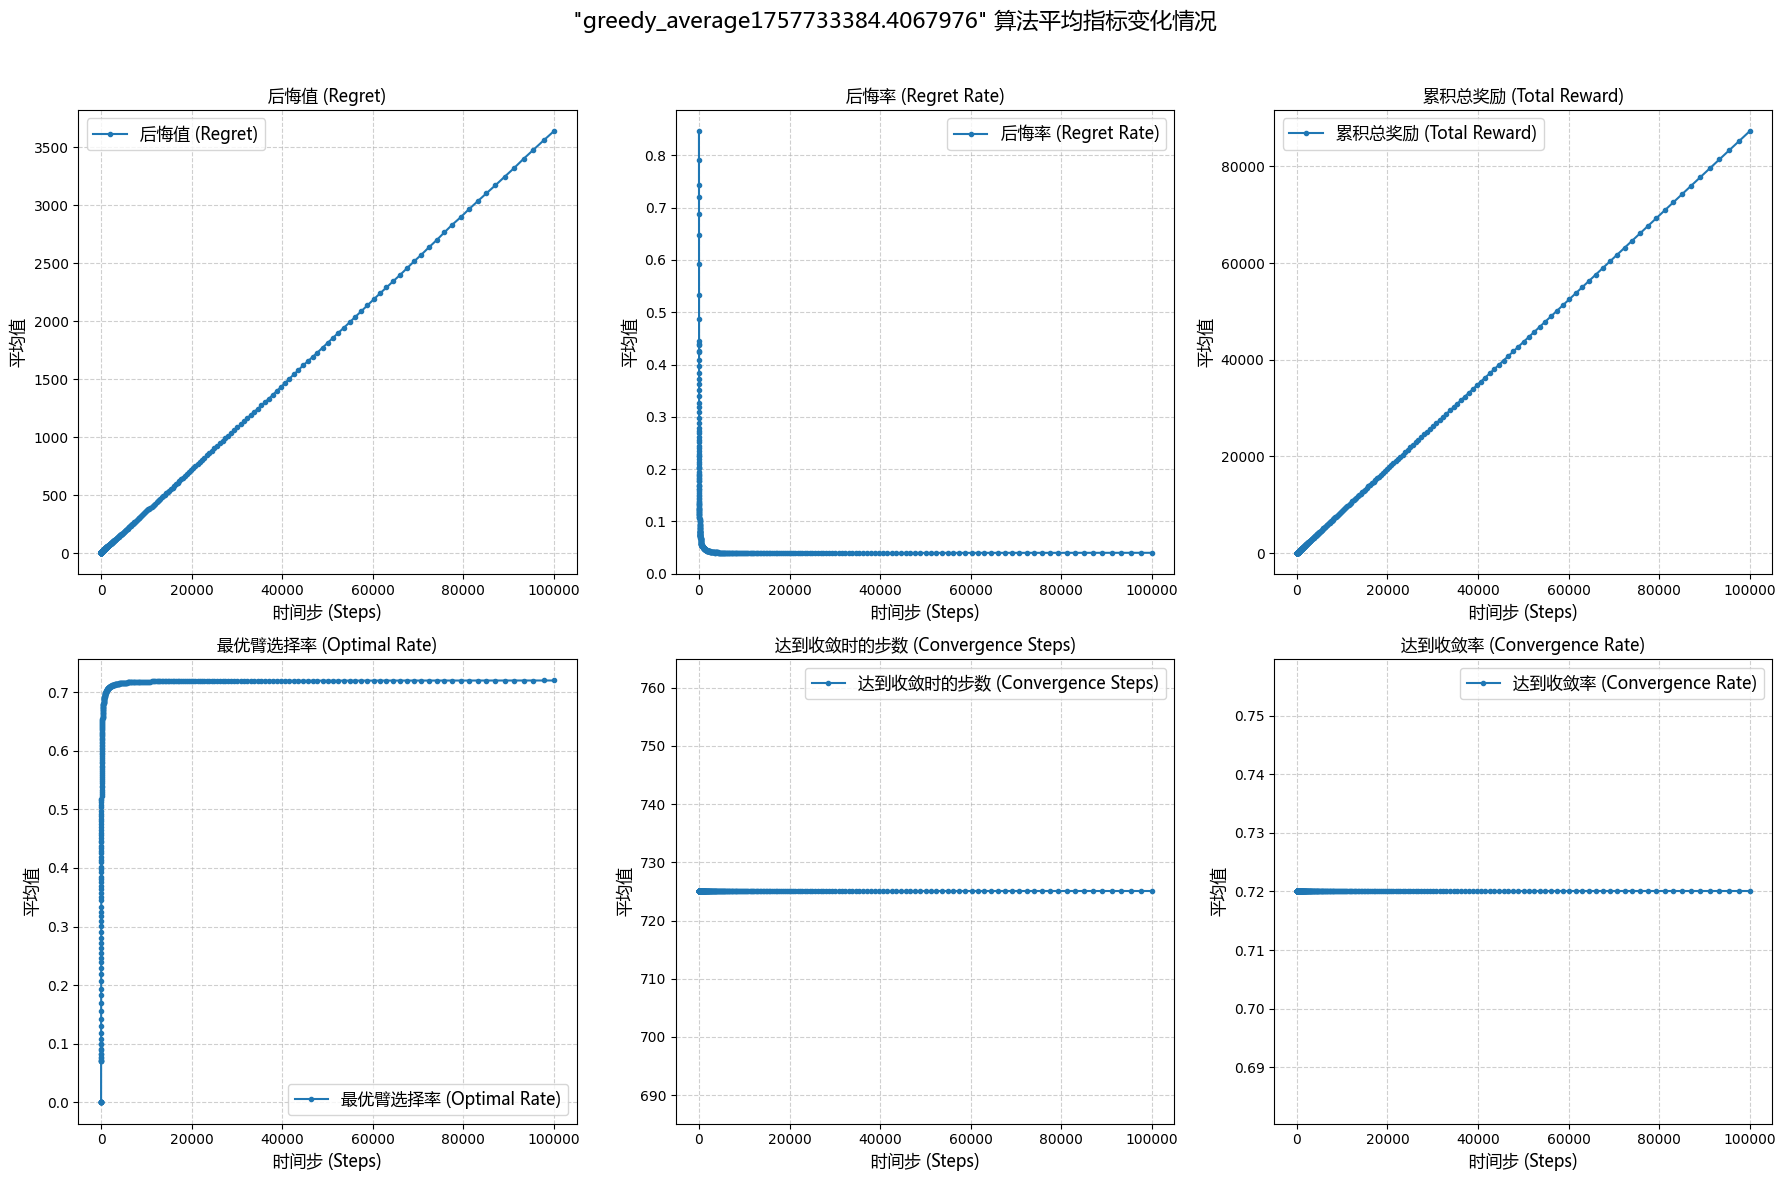

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/greedy_average1757733384.4067976_T=100000_K=10_Q_0=1.png
✅ 实验结果数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/greedy_average1757733384.4067976_T=100000_K=10_Q_0=1.json
✅ 过程数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/greedy_average1757733384.4067976_T=100000_K=10_Q_0=1process.json


22856

In [6]:
run_id = get_run_id(greedy_average.__name__)
file_name: Path =EXPERIMENT_DATA_DIR / f"{run_id}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
process_logger = ProcessDataLogger(
    run_id=run_id,
    total_steps=STEPS,
    grid_size=GRID_SIZE,
)

agents, reward, metrics = batch_train(
    count=COUNT,
    agent_factory=create_greedy_agent,
    env=ENV,
    epsilon_config=EPSILON_CONFIG,
    steps=STEPS,
    seed=SEED,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    process_logger=process_logger
)
print(metrics)
print(reward)

plot_metrics_history(agents, run_id, file_name)
save_experiment_data(reward, metrics, file_name)
process_logger.save(file_name.with_stem(file_name.stem + "process"), total_steps=STEPS)
dump = process_logger.export(total_steps=STEPS)
keys = list(dump.points[0].data.keys())

del agents, reward, metrics, process_logger, dump
gc.collect()

## epsilon-贪婪算法

达到收敛时的步数: 3960
达到收敛时的步数: 2130
达到收敛时的步数: 1750
达到收敛时的步数: 1510
达到收敛时的步数: 1000
达到收敛时的步数: 4360
达到收敛时的步数: 3360
达到收敛时的步数: 1020
达到收敛时的步数: 2200
达到收敛时的步数: 1840
达到收敛时的步数: 1840
达到收敛时的步数: 3100
达到收敛时的步数: 23640
达到收敛时的步数: 62460
达到收敛时的步数: 5920
达到收敛时的步数: 2100
达到收敛时的步数: 1000
达到收敛时的步数: 1000
达到收敛时的步数: 1890
达到收敛时的步数: 1120
达到收敛时的步数: 1000
达到收敛时的步数: 4070
达到收敛时的步数: 1080
达到收敛时的步数: 4190
达到收敛时的步数: 3250
达到收敛时的步数: 1480
达到收敛时的步数: 21160
达到收敛时的步数: 1550
达到收敛时的步数: 3160
达到收敛时的步数: 1000
达到收敛时的步数: 15450
达到收敛时的步数: 1140
达到收敛时的步数: 1000
达到收敛时的步数: 2460
达到收敛时的步数: 1000
达到收敛时的步数: 1110
达到收敛时的步数: 6360
达到收敛时的步数: 15230
达到收敛时的步数: 3390
达到收敛时的步数: 3480
达到收敛时的步数: 1650
达到收敛时的步数: 5000
达到收敛时的步数: 2170
达到收敛时的步数: 4990
avg_regret=4132.110909090912 avg_regret_rate=0.04545322000000002 avg_total_reward=86776.98 avg_optimal_rate=0.9070833999999999 avg_convergence_steps=4671.4 avg_convergence_rate=0.88
values=[90.12, 182.54, 270.08, 365.64, 458.2, 547.48, 654.06, 748.06, 1007.26, 82453.54] counts=[999.76, 1002.66, 994.04, 1005.2, 1004.52, 1002.84, 1025.

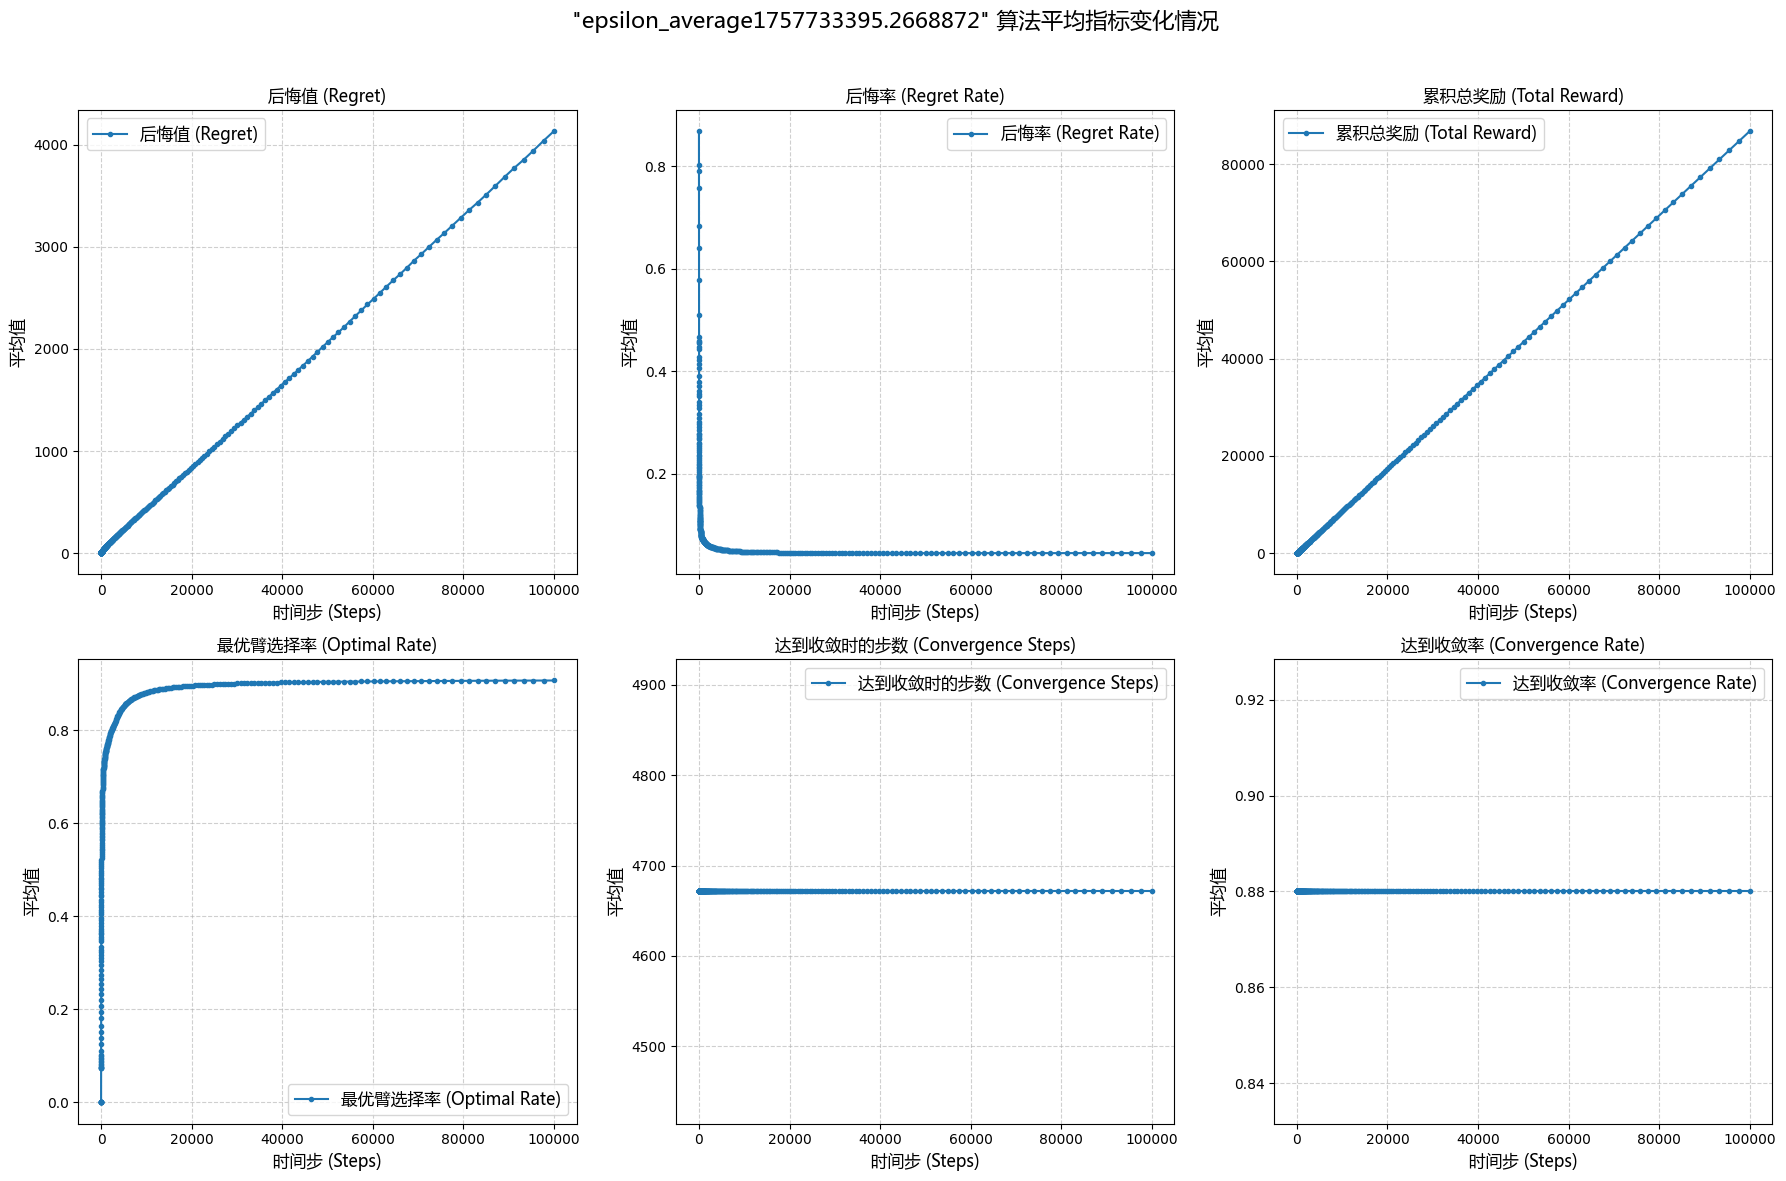

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_average1757733395.2668872_T=100000_K=10_Q_0=1.png
✅ 实验结果数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_average1757733395.2668872_T=100000_K=10_Q_0=1.json
✅ 过程数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_average1757733395.2668872_T=100000_K=10_Q_0=1process.json


20862

In [7]:
run_id = get_run_id(epsilon_average.__name__)
file_name: Path =EXPERIMENT_DATA_DIR / f"{run_id}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
process_logger = ProcessDataLogger(
    run_id=run_id,
    total_steps=STEPS,
    grid_size=GRID_SIZE,
)

agents, reward, metrics = batch_train(
    count=COUNT,
    agent_factory=create_epsilon_agent,
    env=ENV,
    epsilon_config=EPSILON_CONFIG,
    steps=STEPS,
    seed=SEED,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    process_logger=process_logger,
)
print(metrics)
print(reward)

plot_metrics_history(agents, run_id, file_name)
save_experiment_data(reward, metrics, file_name)
process_logger.save(file_name.with_stem(file_name.stem + "process"), total_steps=STEPS)
dump = process_logger.export(total_steps=STEPS)
keys = list(dump.points[0].data.keys())

del agents, reward, metrics, process_logger, dump
gc.collect()

## 退火 epsilon 贪婪算法

达到收敛时的步数: 2510
达到收敛时的步数: 2020
达到收敛时的步数: 2230
达到收敛时的步数: 2290
达到收敛时的步数: 2040
达到收敛时的步数: 1860
达到收敛时的步数: 1990
达到收敛时的步数: 2230
达到收敛时的步数: 2570
达到收敛时的步数: 2230
达到收敛时的步数: 5030
达到收敛时的步数: 2420
达到收敛时的步数: 5630
达到收敛时的步数: 2170
达到收敛时的步数: 1650
达到收敛时的步数: 2740
达到收敛时的步数: 1870
达到收敛时的步数: 2080
达到收敛时的步数: 2150
达到收敛时的步数: 2340
达到收敛时的步数: 2080
达到收敛时的步数: 2330
达到收敛时的步数: 1930
达到收敛时的步数: 2960
达到收敛时的步数: 2150
达到收敛时的步数: 2150
达到收敛时的步数: 2940
达到收敛时的步数: 1920
达到收敛时的步数: 2010
达到收敛时的步数: 2070
达到收敛时的步数: 1760
达到收敛时的步数: 1990
达到收敛时的步数: 2160
达到收敛时的步数: 2800
达到收敛时的步数: 2080
达到收敛时的步数: 2100
达到收敛时的步数: 2170
达到收敛时的步数: 1870
达到收敛时的步数: 1860
达到收敛时的步数: 2100
达到收敛时的步数: 1950
达到收敛时的步数: 2150
达到收敛时的步数: 2170
达到收敛时的步数: 2080
达到收敛时的步数: 1910
达到收敛时的步数: 1960
avg_regret=659.6309090909117 avg_regret_rate=0.007255940000000027 avg_total_reward=90249.46 avg_optimal_rate=0.9689806000000002 avg_convergence_steps=2114.0 avg_convergence_rate=0.92
values=[10.82, 22.32, 32.88, 43.08, 55.9, 65.6, 79.52, 91.84, 1742.5, 88105.0] counts=[116.84, 120.52, 119.0, 119.32, 123.14, 1

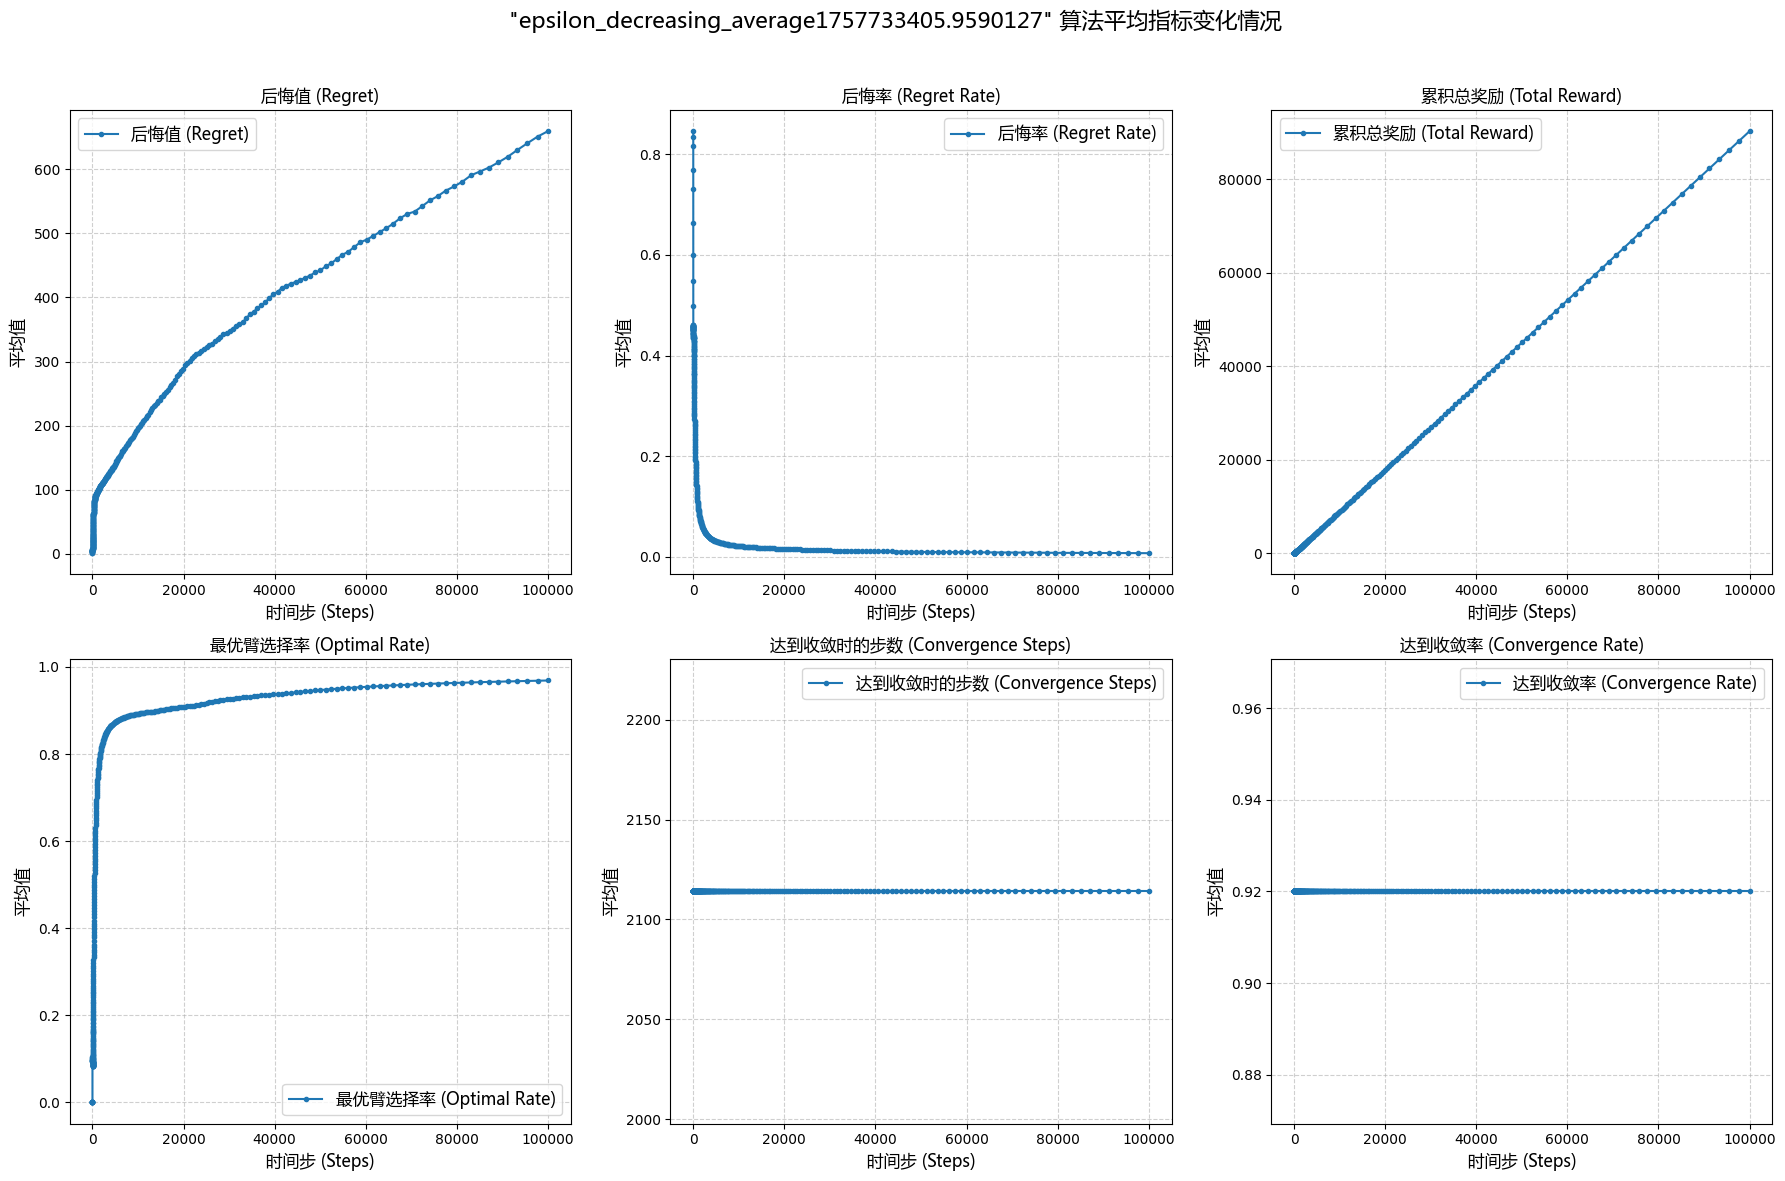

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_decreasing_average1757733405.9590127_T=100000_K=10_Q_0=1.png
✅ 实验结果数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_decreasing_average1757733405.9590127_T=100000_K=10_Q_0=1.json
✅ 过程数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/epsilon_decreasing_average1757733405.9590127_T=100000_K=10_Q_0=1process.json


21368

In [8]:
run_id = get_run_id(epsilon_decreasing_average.__name__)
file_name: Path =EXPERIMENT_DATA_DIR / f"{run_id}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
process_logger = ProcessDataLogger(
    run_id=run_id,
    total_steps=STEPS,
    grid_size=GRID_SIZE,
)

agents, reward, metrics = batch_train(
    count=COUNT,
    agent_factory=create_decreasing_agent,
    env=ENV,
    epsilon_config=EPSILON_CONFIG,
    steps=STEPS,
    seed=SEED,
    optimistic_init=ENABLE_OPTIMISTIC,
    optimistic_times=OPTIMISTIC_TIMES,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    process_logger=process_logger,
)
print(metrics)
print(reward)

plot_metrics_history(agents, run_id, file_name)
save_experiment_data(reward, metrics, file_name)
process_logger.save(file_name.with_stem(file_name.stem + "process"), total_steps=STEPS)
dump = process_logger.export(total_steps=STEPS)
keys = list(dump.points[0].data.keys())

del agents, reward, metrics, process_logger, dump
gc.collect()

## UCB1算法

达到收敛时的步数: 23610
达到收敛时的步数: 24150
达到收敛时的步数: 21950
达到收敛时的步数: 21250
达到收敛时的步数: 25830
达到收敛时的步数: 23900
达到收敛时的步数: 27730
达到收敛时的步数: 23910
达到收敛时的步数: 19970
达到收敛时的步数: 21030
达到收敛时的步数: 24920
达到收敛时的步数: 26680
达到收敛时的步数: 23220
达到收敛时的步数: 25480
达到收敛时的步数: 18600
达到收敛时的步数: 24500
达到收敛时的步数: 22730
达到收敛时的步数: 24270
达到收敛时的步数: 22700
达到收敛时的步数: 25340
达到收敛时的步数: 20800
达到收敛时的步数: 26510
达到收敛时的步数: 21920
达到收敛时的步数: 26760
达到收敛时的步数: 22700
达到收敛时的步数: 24480
达到收敛时的步数: 21780
达到收敛时的步数: 28000
达到收敛时的步数: 22920
达到收敛时的步数: 23510
达到收敛时的步数: 22450
达到收敛时的步数: 25320
达到收敛时的步数: 24580
达到收敛时的步数: 29200
达到收敛时的步数: 24310
达到收敛时的步数: 23710
达到收敛时的步数: 24010
达到收敛时的步数: 20570
达到收敛时的步数: 22860
达到收敛时的步数: 23660
达到收敛时的步数: 20080
达到收敛时的步数: 17130
达到收敛时的步数: 23800
达到收敛时的步数: 20920
达到收敛时的步数: 25900
达到收敛时的步数: 18040
达到收敛时的步数: 20970
达到收敛时的步数: 24450
达到收敛时的步数: 24450
达到收敛时的步数: 25990
avg_regret=601.6909090909118 avg_regret_rate=0.00661860000000003 avg_total_reward=90307.4 avg_optimal_rate=0.9667879999999996 avg_convergence_steps=23471.0 avg_convergence_rate=1.0
values=[3.24, 8.18,

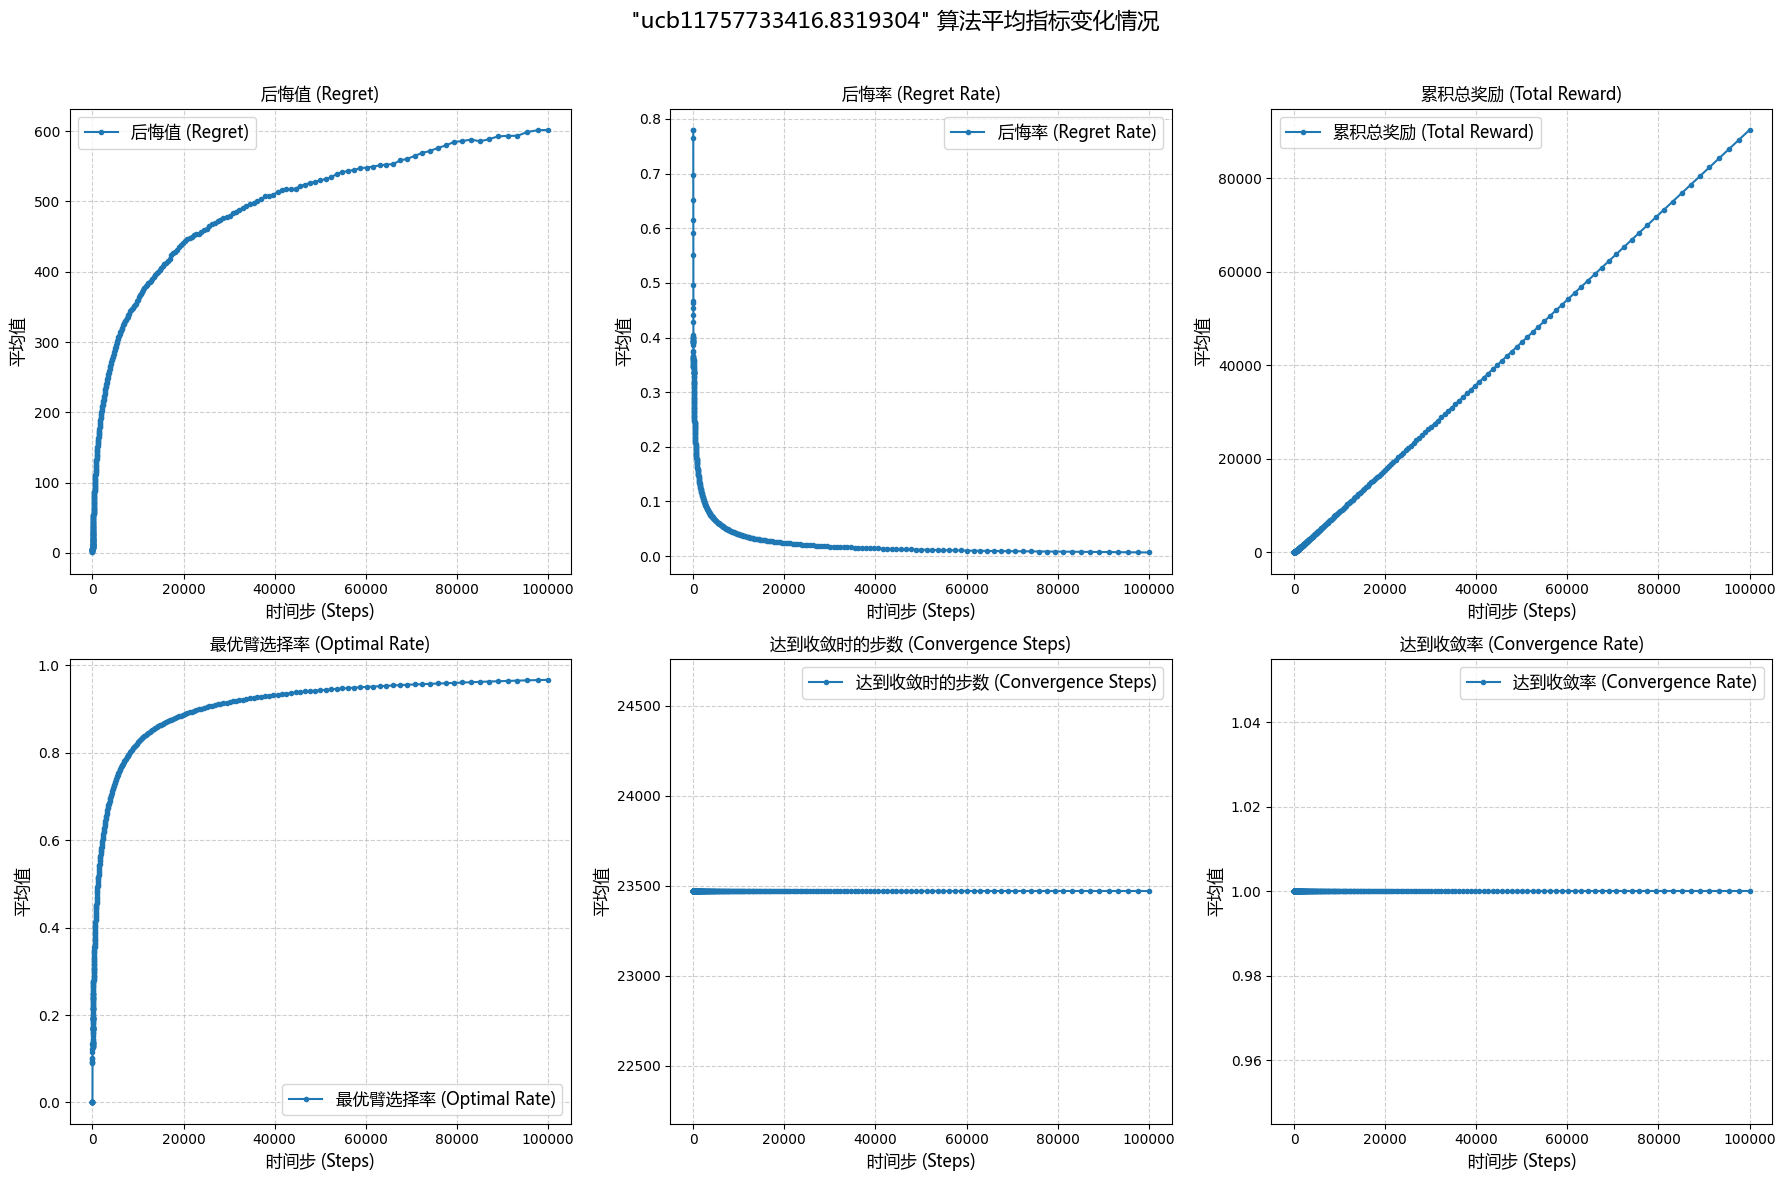

✅ 图表已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/ucb11757733416.8319304_T=100000_K=10_Q_0=1.png
✅ 实验结果数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/ucb11757733416.8319304_T=100000_K=10_Q_0=1.json
✅ 过程数据已保存至 /home/Jese__Ki/Projects/learn/Python/rl_atomic/bandit/experiment_data/ucb11757733416.8319304_T=100000_K=10_Q_0=1process.json


21849

In [9]:
run_id = get_run_id(ucb1.__name__)
file_name: Path =EXPERIMENT_DATA_DIR / f"{run_id}_T={STEPS}_K={MACHINE_COUNT}_Q_0={OPTIMISTIC_TIMES}.png"
process_logger = ProcessDataLogger(
    run_id=run_id,
    total_steps=STEPS,
    grid_size=GRID_SIZE,
)

agents, reward, metrics = batch_train(
    count=COUNT,
    agent_factory=create_ucb1_agent,
    env=ENV,
    steps=STEPS,
    seed=SEED,
    convergence_threshold=CONVERGENCE_THRESHOLD,
    convergence_min_steps=CONVERGENCE_MIN_STEPS,
    process_logger=process_logger,
)
print(metrics)
print(reward)

plot_metrics_history(agents, run_id, file_name)
save_experiment_data(reward, metrics, file_name)
process_logger.save(file_name.with_stem(file_name.stem + "process"), total_steps=STEPS)
dump = process_logger.export(total_steps=STEPS)
keys = list(dump.points[0].data.keys())

del agents, reward, metrics, process_logger, dump
gc.collect()